# sprint22 深層学習スクラッチRNN

## リカレントニューラルネットワークスクラッチ

リカレントニューラルネットワーク（RNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


フォワードプロパゲーションの実装を必須課題とし、バックプロパゲーションの実装はアドバンス課題とします。


クラスの名前はScratchSimpleRNNClassifierとしてください。クラスの構造などは以前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください

## 【問題1】SimpleRNNのフォワードプロパゲーション実装

SimpleRNNのクラスSimpleRNNを作成してください。基本構造はFCクラスと同じになります。


フォワードプロパゲーションの数式は以下のようになります。ndarrayのshapeがどうなるかを併記しています。


バッチサイズをbatch_size、入力の特徴量数をn_features、RNNのノード数をn_nodesとして表記します。活性化関数はtanhとして進めますが、これまでのニューラルネットワーク同様にReLUなどに置き換えられます。

$$
a_t = x_{t}\cdot W_{x} + h_{t-1}\cdot W_{h} + B\\
h_t = tanh(a_t)
$$

$a_t$ : 時刻tの活性化関数を通す前の状態 (batch_size, n_nodes)


$h_t$ : 時刻tの状態・出力 (batch_size, n_nodes)


$x_{t}$ : 時刻tの入力 (batch_size, n_features)


$W_{x}$ : 入力に対する重み (n_features, n_nodes)


$h_{t-1}$ : 時刻t-1の状態（前の時刻から伝わる順伝播） (batch_size, n_nodes)


$W_{h}$ : 状態に対する重み。 (n_nodes, n_nodes)


$B$ : バイアス項 (n_nodes,)


初期状態 $h_{0}$ は全て0とすることが多いですが、任意の値を与えることも可能です。


上記の処理を系列数n_sequences回繰り返すことになります。RNN全体への入力 $x$ は(batch_size, n_sequences, n_features)のような配列で渡されることになり、そこから各時刻の配列を取り出していきます。


分類問題であれば、それぞれの時刻のhに対して全結合層とソフトマックス関数（またはシグモイド関数）を使用します。タスクによっては最後の時刻のhだけを使用することもあります。

In [1]:
import numpy as np

### 初期値

In [8]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [9]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1/np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### 活性化関数

In [10]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.Z = 1/(1+np.exp(-A)) 
        return self.Z
    
    def backward(self, dZ):
        dA = dZ * (1 - self.Z) * self.Z
        return dA

In [11]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        
        self.Z = np.tanh(A)
        return self.Z
    
    def backward(self, dZ):
        dA = dZ * (1 - self.Z**2)    #tanh関数の微分
        return dA

In [12]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.Z = np.exp(A)/np.sum(np.exp(A), axis=1, keepdims=True)
        return self.Z
    
    def backward(self, ty):
        dA = self.Z - ty
        return dA

In [13]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.Z = np.maximum(A, 0)
        return self.Z
    
    def backward(self,dZ):
        dA = np.where(self.Z > 0, dZ, 0)
        return dA

### 最適化手法

In [14]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr, hw, hb):
        self.lr = lr
        self.hw = hw
        self.hb = hb
        
    def update(self, layer):
        self.hw = layer.dW**2 + self.hw
        layer.w -= self.lr * np.sqrt(self.hw) * layer.dW
        
        self.hb = layer.dB**2 + self.hb
        layer.b -= self.lr * np.sqrt(self.hb) *  layer.dB
        
        return layer

In [140]:
class AdaGrad_RNN:
    """
    AdaGrad RNN
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr, hw_x, hw_h, hb):
        self.lr = lr
        self.hw_x = hw_x
        self.hw_h = hw_h
        self.hb = hb
        
    def update(self, layer):
        self.hw_x = layer.dW_x**2 + self.hw_x
        layer.w_x -= self.lr * np.sqrt(self.hw_x) * layer.dW_X
        
        self.hw_h = layer.dW_h**2 + self.hw_h
        layer.w_h -= self.lr * np.sqrt(self.hw_h) * layer.dW_h
        
        self.hb = layer.dB**2 + self.hb
        layer.b -= self.lr * np.sqrt(self.hb) *  layer.dB
        
        return layer

### SimpleRNN

In [80]:
class SimpleRNN:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_features : int
      特徴量数
    n_nodes : int
      ノード数
    batch_size : int
      バッチサイズ
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
        
    def __init__(self, n_features, n_nodes, batch_size, initializer=None, optimizer=None):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、初期化する
        """
        self.w_x = initializer.W(n_features, n_nodes)
        self.w_h = initializer.W(n_nodes, n_nodes)
        self.b = initializer.B(n_nodes)
        self.h = initializer.W(batch_size, n_nodes)
        """
        self.w_x = np.array([[1, 3, 5, 7], [3, 5, 7, 8]])/100 # (n_features, n_nodes)
        self.w_h = np.array([[1, 3, 5, 7], [2, 4, 6, 8], [3, 5, 7, 8], [4, 6, 8, 10]])/100 # (n_nodes, n_nodes)
        self.h = np.zeros((batch_size, n_nodes)) # (batch_size, n_nodes)
        self.b = np.array([1, 1, 1, 1]) # (n_nodes,)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_features)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        self.X = X
        A = np.dot(self.X, self.w_x) + np.dot(self.h, self.w_h) + self.b
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dW = np.dot(self.X.T, dA)
        self.dB = np.sum(dA, axis=0)
        self.dZ = np.dot(dA, self.w.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return self.dZ

### SimpleRNN2

In [136]:
class SimpleRNN2:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_features : int
      特徴量数
    n_nodes : int
      ノード数
    batch_size : int
      バッチサイズ
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
        
    def __init__(self, n_features, n_nodes, batch_size, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、初期化する
        
        self.w_x = initializer.W(n_features, n_nodes)
        self.w_h = initializer.W(n_nodes, n_nodes)
        self.b = initializer.B(n_nodes)
        self.h_bf = initializer.W(batch_size, n_nodes)
        self.h = initializer.W(batch_size, n_nodes)
        self.dW_x = np.zeros_like(self.w_x)
        self.dW_h = np.zeros_like(self.w_h)
        self.dB = np.zeros_like(self.b)
        self.dH_bf = np.zeros_like(self.h_bf)
        
        # リセット
        self.dW_x = np.zeros_like(self.w_x)
        self.dW_h = np.zeros_like(self.w_h)
        self.dB = np.zeros_like(self.b)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_features)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        self.X = X
        A = np.dot(self.X, self.w_x) + np.dot(self.h_bf, self.w_h) + self.b
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA, axis=0)
        self.dW_x = np.dot(self.X.T, dA)
        self.dW_h = np.dot(self.dH_bf.T, dA)
        
        dH_bf = np.dot(dA, self.w_h.T)
        dZ = np.dot(dA, self.w_x.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return dZ, dH_bf
        

### FC

In [123]:
#Full Connected Layer Class
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
        
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        print("n_nodes1", n_nodes1)
        print("n_nodes2", n_nodes2)
        self.w = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.X = X
        A = np.dot(self.X, self.w) + self.b
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dW = np.dot(self.X.T, dA)
        self.dB = np.sum(dA, axis=0)
        self.dZ = np.dot(dA, self.w.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return self.dZ

### ScratchSimpleRNNClassifier

In [60]:
class ScratchSimpleRNNClassifier:
    def __init__(self, lr=0.01 ,sigma=0.01, n_features=4):
        self.lr = lr     # 学習係数
        self.sigma = sigma    # 重みとバイアスの広がり具合
        self.n_features = n_features
        
    
    def fit(self, X, Initializer, activations, opt="SGD", batch_size=1):
        
        #self.loss = np.zeros(epoch)
        self.activation_list = []
        self.RNN_list = []
        self.n_sequences = X.shape[1]    # 時系列数
        
        # インスタンス生成---------------------------------------------------
        #for i in range(len(self.nodes_list)-1):
        # 初期値----------------------------------------
        """
        if Initializer[i] == "Simple":
            initializ = SimpleInitializer(self.sigma)
        elif Initializer[i] == "Xavier":
            initializ = XavierInitializer()
        else:
            initializ = HeInitializer()
        """
        # 最適化手法-----------------------------------
        """
        if opt == "SGD":
            optimizer = SGD(self.lr)
        else:
            optimizer = AdaGrad(self.lr, 0, 0)
        """
        # RNN層インスタンス生成-------------------
        self.RNN_list.append(SimpleRNN(self.n_features, n_nodes, batch_size))

        # 活性化関数インスタンス生成----------------
        if activations[0] == "tanh":
            self.activation_list.append(Tanh() )
        elif activations[i] == "sigmoid":
            self.activation_list.append(Sigmoid() )
        else:
            self.activation_list.append(ReLU() )

        # -----------------------------------------------------------------end
        
        
        for i in range(self.n_sequences):
            #get_mini_batch = GetMiniBatch(X, y_onehot, batch_size)    # ミニバッチ生成
            #for mini_X_train, mini_y_train in get_mini_batch:    # ミニバッチ学習則
                
            A = self.RNN_list[0].forward(X[:,i,:])    # RNN層
            Z = self.activation_list[0].forward(A)
            self.RNN_list[0].h = Z
            print("Z : ",  Z)
            
            """
            for j in range(1, len(self.nodes_list)-1):    # 中間層&出力層
                A = self.FC_list[j].forward(Z)
                Z = self.activation_list[j].forward(A)

            dA = self.activation_list[-1].backward(mini_y_train) # 出力層
            dZ = self.FC_list[-1].backward(dA)

            for j in reversed(range(1, len(self.nodes_list)-2)):    # 中間層
                dA = self.activation_list[j].backward(dZ)
                dZ = self.FC_list[j].backward(dA)

            dA = self.activation_list[0].backward(dZ)    # 入力層
            dZ = self.FC_list[0].backward(dA)
            
                
            yp = self.predict(X)
            # 損失関数
            self.loss[i] = -np.sum(y_onehot * np.log(self.predict_y))/ self.predict_y.shape[1]
            """
    def predict(self,X):
        A = self.FC_list[0].forward(X)    # 入力層
        Z = self.activation_list[0].forward(A)
                
        for j in range(1, len(self.nodes_list)-1):    # 中間層&出力層
            A = self.FC_list[j].forward(Z)
            Z = self.activation_list[j].forward(A)
            
        self.predict_y = Z.copy()
        
        return np.argsort(Z)[:,-1]

## 【問題2】小さな配列でのフォワードプロパゲーションの実験

小さな配列でフォワードプロパゲーションを考えてみます。


入力x、初期状態h、重みw_xとw_h、バイアスbを次のようにします。


ここで配列xの軸はバッチサイズ、系列数、特徴量数の順番です。

In [17]:
x = np.array([[[1, 2], [2, 3], [3, 4]]])/100 # (batch_size, n_sequences, n_features)
w_x = np.array([[1, 3, 5, 7], [3, 5, 7, 8]])/100 # (n_features, n_nodes)
w_h = np.array([[1, 3, 5, 7], [2, 4, 6, 8], [3, 5, 7, 8], [4, 6, 8, 10]])/100 # (n_nodes, n_nodes)
batch_size = x.shape[0] # 1
n_sequences = x.shape[1] # 3
n_features = x.shape[2] # 2
n_nodes = w_x.shape[1] # 4
h = np.zeros((batch_size, n_nodes)) # (batch_size, n_nodes)
b = np.array([1, 1, 1, 1]) # (n_nodes,)

フォワードプロパゲーションの出力が次のようになることを作成したコードで確認してください。
h = np.array([[0.79494228, 0.81839002, 0.83939649, 0.85584174]]) # (batch_size, n_nodes)

In [147]:
w_h

array([[0.01, 0.03, 0.05, 0.07],
       [0.02, 0.04, 0.06, 0.08],
       [0.03, 0.05, 0.07, 0.08],
       [0.04, 0.06, 0.08, 0.1 ]])

In [61]:
#n_features, n_nodes, batch_size
sc_rnn = ScratchSimpleRNNClassifier()
sc_rnn.fit(x, Initializer=["Xavier"], activations=["tanh"])

Z :  [[0.76188798 0.76213958 0.76239095 0.76255841]]
Z :  [[0.792209   0.8141834  0.83404912 0.84977719]]
Z :  [[0.79494228 0.81839002 0.83939649 0.85584174]]


## 【問題3】（アドバンス課題）バックプロパゲーションの実装

バックプロパゲーションを実装してください。


RNNの内部は全結合層を組み合わせた形になっているので、更新式は全結合層などと同様です。

$$
W_x^{\prime} = W_x - \alpha \frac{\partial L}{\partial W_x} \\
W_h^{\prime} = W_h - \alpha \frac{\partial L}{\partial W_h} \\
B^{\prime} = B - \alpha \frac{\partial L}{\partial B}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial W_x}$ : $W_x$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial W_h}$ : $W_h$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B}$ : $B$ に関する損失 $L$ の勾配


勾配を求めるためのバックプロパゲーションの数式が以下です。


$\frac{\partial h_t}{\partial a_t} = \frac{\partial L}{\partial h_t} ×(1-tanh^2(a_t))$


$\frac{\partial L}{\partial B} = \frac{\partial h_t}{\partial a_t}$


$\frac{\partial L}{\partial W_x} = x_{t}^{T}\cdot \frac{\partial h_t}{\partial a_t}$


$\frac{\partial L}{\partial W_h} = h_{t-1}^{T}\cdot \frac{\partial h_t}{\partial a_t}$


＊$\frac{\partial L}{\partial h_t}$ は前の時刻からの状態の誤差と出力の誤差の合計です。hは順伝播時に出力と次の層に伝わる状態双方に使われているからです。


前の時刻や層に流す誤差の数式は以下です。


$\frac{\partial L}{\partial h_{t-1}} = \frac{\partial h_t}{\partial a_t}\cdot W_{h}^{T}$


$\frac{\partial L}{\partial x_{t}} = \frac{\partial h_t}{\partial a_t}\cdot W_{x}^{T}$

RNNの中の計算（順伝播）

In [158]:
a_0 = x[:,0,:] @ w_x + h @ w_h + b

In [159]:
ht_0 = np.tanh(a_0)

In [160]:
a_1 = x[:,1,:] @ w_x + ht_0 @ w_h + b

In [161]:
ht_1 = np.tanh(a_1)

In [162]:
a_2 = x[:,1,:] @ w_x + ht_1 @ w_h + b

In [163]:
ht_2 = np.tanh(a_2)

In [164]:
ht_2

array([[0.79479501, 0.81812566, 0.83904164, 0.85543992]])

逆伝播

In [191]:
# 仮のloss
loss_2 = [[1.0, 1.5, 2.0, 2.5]]

$\frac{\partial h_t}{\partial a_t} = \frac{\partial L}{\partial h_t} ×(1-tanh^2(a_t))$

In [192]:
dA_2 = loss_2 * (1 - ht_2**2)   # tanhの微分
dA_2

array([[0.3683009 , 0.4960056 , 0.59201827, 0.67055636]])

$\frac{\partial L}{\partial B} = \frac{\partial h_t}{\partial a_t}$

In [193]:
dB = np.sum(dA_2, axis=0)
dB

array([0.3683009 , 0.4960056 , 0.59201827, 0.67055636])

$\frac{\partial L}{\partial W_x} = x_{t}^{T}\cdot \frac{\partial h_t}{\partial a_t}$

In [194]:
dW_x = x[:,2,:] .T @ dA_2
dW_x

array([[0.01104903, 0.01488017, 0.01776055, 0.02011669],
       [0.01473204, 0.01984022, 0.02368073, 0.02682225]])

$\frac{\partial L}{\partial W_h} = h_{t-1}^{T}\cdot \frac{\partial h_t}{\partial a_t}$

In [195]:
dW_h = ht_1.T @ dA_2
dW_h

array([[0.29177129, 0.39294011, 0.4690022 , 0.53122078],
       [0.29986448, 0.40383953, 0.48201145, 0.54595585],
       [0.30718104, 0.41369304, 0.49377232, 0.55927694],
       [0.3129737 , 0.42149425, 0.50308362, 0.5698235 ]])

$\frac{\partial L}{\partial h_{t-1}} = \frac{\partial h_t}{\partial a_t}\cdot W_{h}^{T}$

In [196]:
dH_t_bf = dA_2 @ w_h.T
dH_t_bf

array([[0.09510304, 0.11637185, 0.13093509, 0.15890947]])

$\frac{\partial L}{\partial x_{t}} = \frac{\partial h_t}{\partial a_t}\cdot W_{x}^{T}$

In [197]:
dX_t = dA_2 @ w_x.T
dX_t

array([[0.09510304, 0.13093509]])

In [198]:
# 仮のloss
loss_1 = [[1.0, 1.5, 2.0, 2.5]]

In [199]:
dA_1= loss_1 * (1 - ht_1**2)   # tanhの微分
dA_1

array([[0.37240489, 0.50565809, 0.60872411, 0.69469682]])

In [200]:
dB = np.sum(dA_1, axis=0)
dB

array([0.37240489, 0.50565809, 0.60872411, 0.69469682])

In [201]:
dW_x = x[:,1,:] .T @ dA_1
dW_x

array([[0.0074481 , 0.01011316, 0.01217448, 0.01389394],
       [0.01117215, 0.01516974, 0.01826172, 0.0208409 ]])

In [ ]:
dW_h = ht_1.T @ dA_1
dW_h

RNN層で各時刻で出力されたypとytのlossが必要なのでは？と疑問に思ったので、持っている本の
RNNスクラッチを少しDiverに合わせて写経する

In [62]:
import matplotlib.pyplot as plt

In [277]:
n_time = 10    # 時系列の数
n_in = 1    # 入力層のニューロン数
n_mid = 20    # 中間層のニューロン数
n_out = 1    # 出力層のニューロン数

eta = 0.001    # 学習率
epoch = 51
batch_size = 8
interval = 5

# 訓練用データの作成
sin_x = np.linspace(-2*np.pi, 2*np.pi)
sin_y = np.sin(sin_x) + 0.1*np.random.randn(len(sin_x))

n_sample = len(sin_x) - n_time    # サンプル数
input_data = np.zeros((n_sample, n_time, n_in))    # 入力
correct_data = np.zeros((n_sample, n_out))     # 正解

for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_sequences].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_sequences:i+n_sequences+1]    # 正解は入力よりも一つ後

In [287]:
class SimpleRNNLayer:
    def __init__(self, n_upper, n):
        # Xavierの初期値
        self.w_x = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.w_h = np.random.randn(n, n)/  np.sqrt(n)
        self.b = np.zeros(n)
        
    def forward(self, x, ht_bf):    # ht_bf:前の時刻の出力
        A = np.dot(x, self.w_x) + np.dot(ht_bf, self.w_h) + self.b
        self.Z = np.tanh(A)
        
    def backward(self, x, ht, ht_bf, dZ):
        dA = dZ * (1 - ht**2)
        
        self.dW_x += np.dot(x.T, dA)
        self.dW_h += np.dot(ht_bf.T, dA)
        self.dB += np.sum(dA, axis=0)
        
        self.dZ = np.dot(dA, self.w_x.T)
        self.dHt_bf = np.dot(dA, self.w_h.T)
        
    def reset_sum_grad(self):
        self.dW_x = np.zeros_like(self.w_x)
        self.dW_h = np.zeros_like(self.w_h)
        self.dB = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w_x -= eta * self.dW_x
        self.w_h -= eta * self.dW_h
        self.b -= eta * self.dB

In [288]:
class OutputLayer:
    def __init__(self, n_upper, n):
        # Xavierの初期値
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        A = np.dot(x, self.w) + self.b
        self.Z = A    # 恒等関数
        
    def backward(self, dZ):
        dA = self.Z - dZ
        self.dW = np.dot(self.x.T, dA)
        self.dB = np.sum(dA, axis=0)
        self.dZ = np.dot(dA, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.dW
        self.b -= eta * self.dB

In [289]:
rnn_layer = SimpleRNNLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [290]:
def train(x_mb, t_mb):
    # 順伝播 RNN層
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    ht_bf = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, ht_bf)
        ht = rnn_layer.Z
        y_rnn[:, i+1, :] = ht
        ht_bf = ht

    # 順伝播 出力層（FC層）
    output_layer.forward(ht)

    # 逆伝播 出力層
    output_layer.backward(t_mb)
    dZ = output_layer.dZ

    # 逆伝播 RNN層
    rnn_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        ht = y_rnn[:, i+1, :]
        ht_bf = y_rnn[:, i, :]
        rnn_layer.backward(x, ht, ht_bf, dZ)
        dZ = rnn_layer.dHt_bf

    # パラメータの更新
    rnn_layer.update(eta)
    output_layer.update(eta)
            

In [291]:
def predict(x_mb):
    # 順伝播 RNN層
    ht_bf = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, ht_bf)
        ht = rnn_layer.Z
        ht_bf = ht
        
    # 出力層
    output_layer.forward(ht)
    return output_layer.Z

In [292]:
def get_error(x, y):
    yp = predict(x)
    return 1.0/ 2.0 * np.sum(np.square(yp - y))

epoch : 1/51 loss : 5.203054080036307


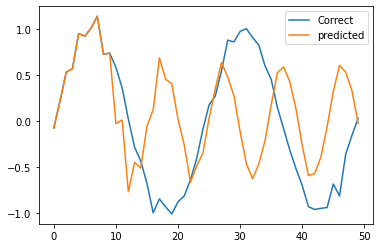

epoch : 6/51 loss : 0.8397697930586976


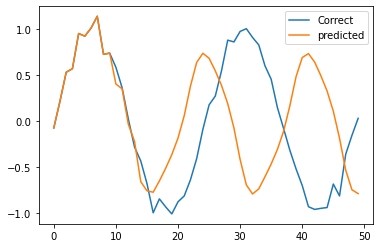

epoch : 11/51 loss : 0.5971542281218952


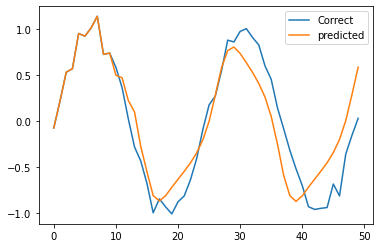

epoch : 16/51 loss : 0.5596088553345333


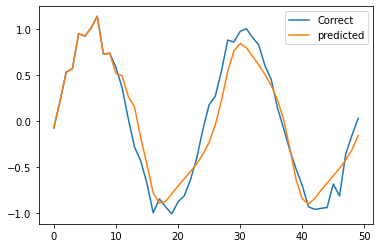

epoch : 21/51 loss : 0.5344862969519765


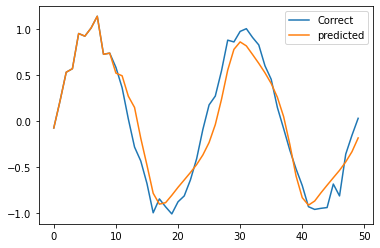

epoch : 26/51 loss : 0.5118116899113057


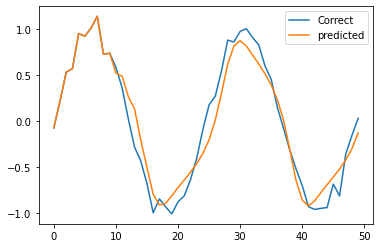

epoch : 31/51 loss : 0.490772211070592


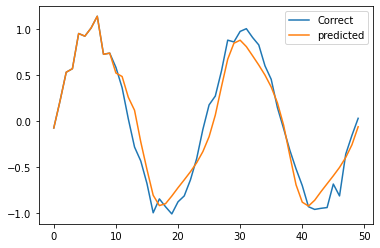

epoch : 36/51 loss : 0.4709418545865317


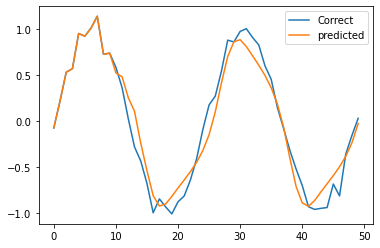

epoch : 41/51 loss : 0.4522306641750905


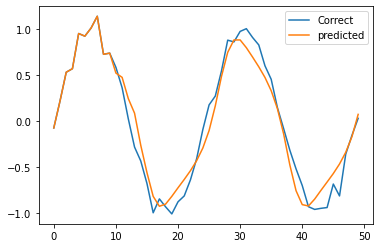

epoch : 46/51 loss : 0.4345412838971946


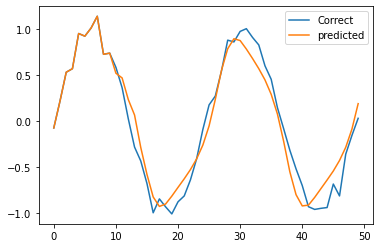

epoch : 51/51 loss : 0.41784039118146976


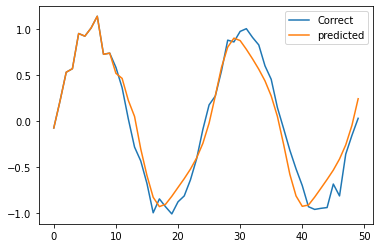

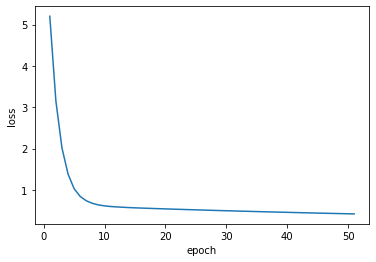

In [293]:
error_record = []
n_batch = len(input_data) // batch_size
for i in range(epoch):
    # 学習
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        # ミニバッチ
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        y_mb = correct_data[mb_index, :]
        train(x_mb, y_mb)
        
    # loss
    error = get_error(input_data, correct_data)
    error_record.append(error)
    
    # plot
    if i%interval==0:
        print("epoch : "+str(i+1)+"/"+str(epoch), "loss : "+str(error))
        
        predicted = input_data[0].reshape(-1).tolist()
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))
            
        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="predicted")
        plt.legend()
        plt.show()
        
plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()